In [1]:
import boto3

client=boto3.client('sts')
account=client.get_caller_identity()['Account']

my_session=boto3.session.Session()
region=my_session.region_name

algorithm_name="pytorch-tft-container-test"
ecr_image='{}.dkr.ecr.{}.amazonaws.com/{}:latest'.format(account, region, algorithm_name)

ecr_image

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


'551329315830.dkr.ecr.us-east-1.amazonaws.com/pytorch-tft-container-test:latest'

In [2]:
import sagemaker
import uuid

sagemaker_session = sagemaker.Session()
print('SageMaker version: ' + sagemaker.__version__)

bucket = sagemaker_session.default_bucket()
prefix = 'sagemaker/DEMO-pytorch-cnn-cifar10'

role = sagemaker.get_execution_role()
checkpoint_suffix = str(uuid.uuid4())[:8]
checkpoint_s3_path = 's3://{}/checkpoint-{}'.format(bucket, checkpoint_suffix)

print('Checkpointing Path: {}'.format(checkpoint_s3_path))

SageMaker version: 2.103.0
Checkpointing Path: s3://sagemaker-us-east-1-551329315830/checkpoint-88b19d96


In [3]:
from utils_cifar import get_train_data_loader, get_test_data_loader, imshow, classes

trainloader = get_train_data_loader()
testloader = get_test_data_loader()

Files already downloaded and verified
Files already downloaded and verified


    horse       cat      ship      deer


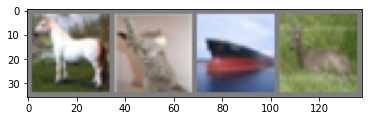

In [4]:
import numpy as np
import torchvision, torch

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join('%9s' % classes[labels[j]] for j in range(4)))

In [5]:
inputs = sagemaker_session.upload_data(path='data', bucket=bucket, key_prefix='data/cifar10')

In [10]:
use_spot_instances = False
max_run=600      # in seconds, after this, job will be terminated
max_wait = 10 * max_run if use_spot_instances else None
local_image_name = 'pytorch-tft-container-test'

's3://sagemaker-us-east-1-551329315830/checkpoint-88b19d96'

In [20]:
from sagemaker.pytorch import PyTorch
from sagemaker.estimator import Estimator


hyperparameters = {'epochs': 10}

spot_estimator  = PyTorch(entry_point='TFT_docker/TFT.py',
                            dependencies=['TFT_docker/requirements.txt'],
                            role=role,
                            framework_version='1.7.1',
                            py_version='py3',
                            instance_count=1,
                            instance_type='ml.p2.xlarge',
                            base_job_name='cifar10-pytorch-spot-1',
                            hyperparameters=hyperparameters,
                            checkpoint_s3_uri=checkpoint_s3_path,
                            debugger_hook_config=False,
                            input_mode = 'FastFile',
                            use_spot_instances=use_spot_instances,
                            max_run=max_run,
                            max_wait=max_wait
                           )

spot_estimator.fit(inputs)

2022-08-21 04:28:47 Starting - Starting the training job...ProfilerReport-1661056127: InProgress
...
2022-08-21 04:29:35 Starting - Preparing the instances for training......
2022-08-21 04:30:43 Downloading - Downloading input data...
2022-08-21 04:31:15 Training - Downloading the training image.................................
2022-08-21 04:36:45 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-08-21 04:36:50,288 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-08-21 04:36:50,315 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-08-21 04:36:50,335 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-08-21 04:36:51,590 sagemaker-training-toolkit INFO     Installing dependencies from requirements.txt:
/opt/conda/bin/python3.6 -m pip in

  Created wheel for fastparquet: filename=fastparquet-0.8.0-cp36-cp36m-linux_x86_64.whl size=1256941 sha256=71ada8e3e20755b28abed51c72af4f4878aaeea65ee44aabe61341c67a342ef7
  Stored in directory: /root/.cache/pip/wheels/6a/6a/4f/0fd8e8bcbc4b5b751186e363b5b03975d8643eee2975eed2ca
  Created wheel for idna-ssl: filename=idna_ssl-1.1.0-py3-none-any.whl size=3161 sha256=a59c626270213c3d4f14f06a866966f8523db97eb5d7810a142839a47e01463e
  Stored in directory: /root/.cache/pip/wheels/6a/f5/9c/f8331a854f7a8739cf0e74c13854e4dd7b1af11b04fe1dde13
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11106 sha256=756dbc76432097ff3a65dec44887fd8143526ff31cead66510cf59afceb4bee3
  Stored in directory: /root/.cache/pip/wheels/95/38/95/e30a7f0b44cb90642de3469f211a3218f93f871789b4f4b46c
Successfully built fastparquet idna-ssl pyperclip
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.0.1
    Uninstalling importlib-metadata-4.0.1:
   

Checkpointing directory /opt/ml/checkpoints exists
Device Type: cuda
Load Stallion dataset
creating dataloader
get GPU information
GPU count: 1
create model trainer
create model from dataset
Number of parameters in network: 29.7k
training model

2022-08-21 04:38:17 Uploading - Uploading generated training model#015Validation sanity check: 0it [00:00, ?it/s]#015Validation sanity check:   0%|          | 0/1 [00:00<?, ?it/s]#015Validation sanity check: 100%|██████████| 1/1 [00:03<00:00,  3.66s/it]#015                                                                      #015GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Restoring states from the checkpoint path at /opt/ml/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/conda/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:251: UserWarning: You're resuming from a checkpoint that ended mid-epoch. Training will start fro

In [ ]:
import pytorch-forecasting0

In [ ]:
# # deploy the trained model
# predictor=estimator.deploy(1, instance_type)